In [2]:
using Kinbiont
using DifferentialEquations
using CSV
using SymbolicRegression
using Plots
using StatsBase
using SymbolicRegression
using Distributions
using OptimizationBBO
using Optimization
using NaNMath


# Generate a dataset with an unknown dependence on a feature 


In [1]:
function unknown_response(feature)
    response = (1 - feature)^2
    return response
end

unknown_response (generic function with 1 method)

In [3]:
function time_dep(time)
    activity = exp((- (time-20)^2)./20)
    return activity
end

time_dep (generic function with 1 method)

In [4]:
function model_1(du, u, param, t)
    # Define the ODEs
    du[1] = param[1] * u[1] * u[4]
    du[2] = time_dep(t)*param[4] * u[1] - param[3] * u[2] - param[2] * u[2]
    du[3] = param[3] * u[2] - param[2] * u[3]
    du[4] = -du[1]
end

model_1 (generic function with 1 method)

In [5]:
u0 = [0.1, 0.0, 0.0,1.0]  # Initial conditions for the variables

4-element Vector{Float64}:
 0.1
 0.0
 0.0
 1.0

In [6]:
# Parameters
param = [0.1, 0.001, 0.5, 0.42]
lb1 =  [0.01, 0.0001, 0.1, 0.0]
ub1=  [0.2, 0.3, 1.1,1.0]
param_guess = lb1 .+ (ub1 .- lb1) ./ 2

4-element Vector{Float64}:
 0.105
 0.15005
 0.6
 0.5

In [7]:
param0 = param[4]
noise_value = 0.01

0.01

In [8]:
# defining the range of the perturbation on feature
results_fit = Any

Any

In [9]:
feature_range = 0.0:0.1:2.0

0.0:0.1:2.0

Experiment with feature as 0.0

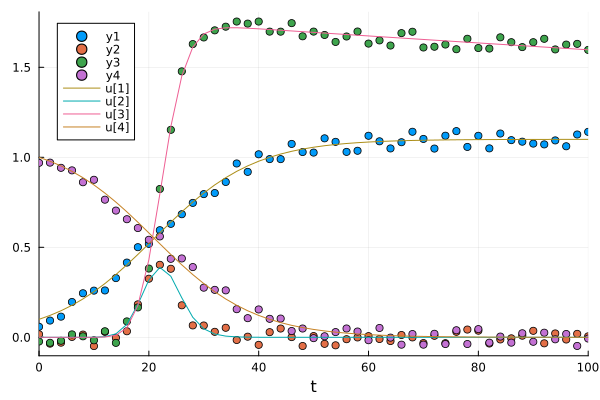

Experiment with feature as 0.1

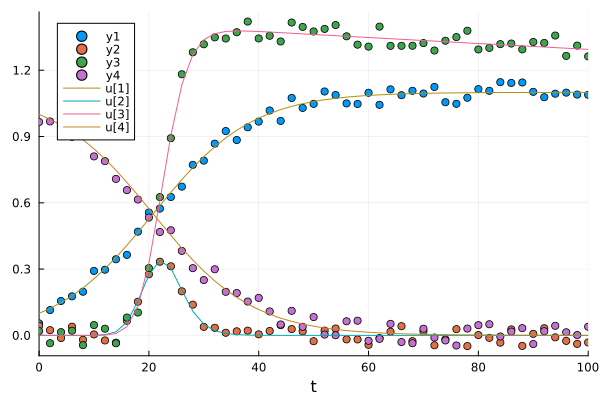

Experiment with feature as 0.2

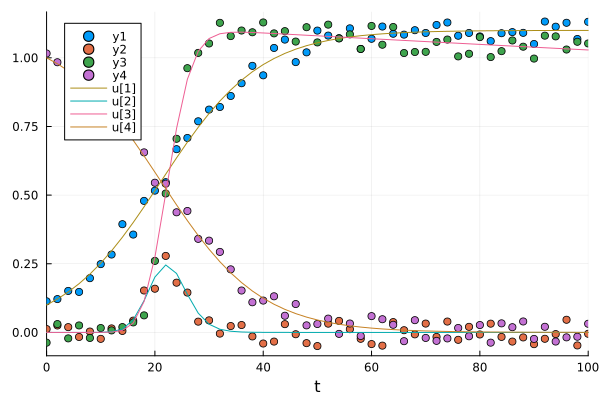

Experiment with feature as 0.3

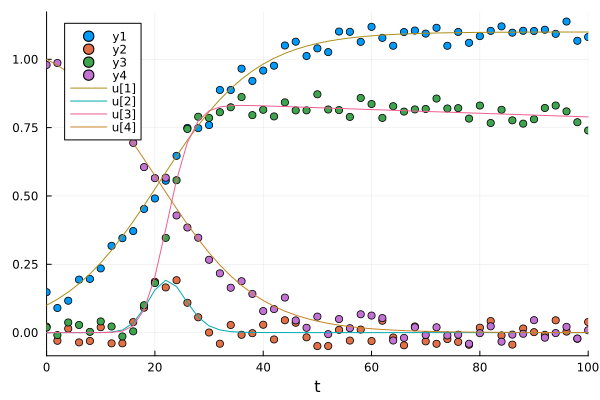

Experiment with feature as 0.4

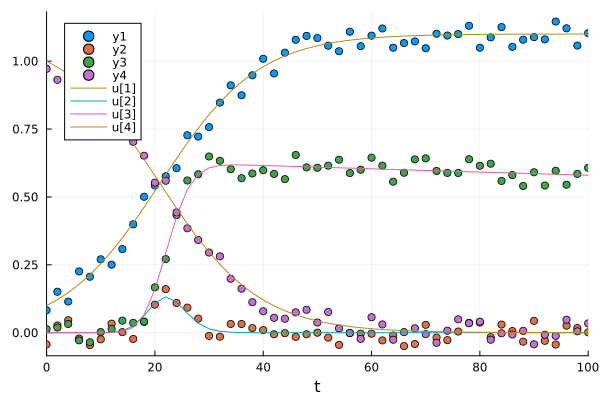

Experiment with feature as 0.5

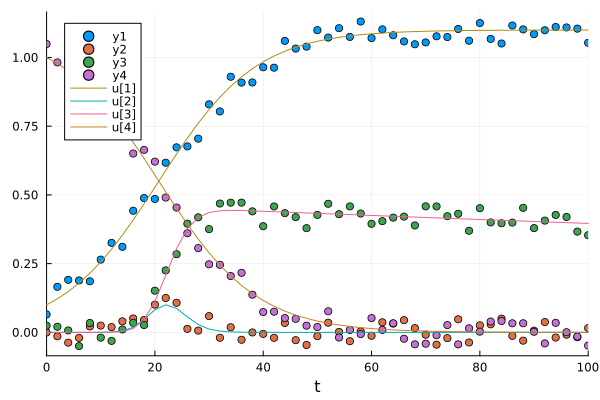

Experiment with feature as 0.6

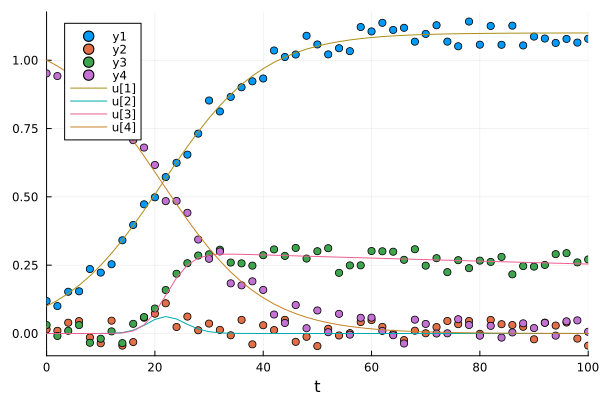

Experiment with feature as 0.7

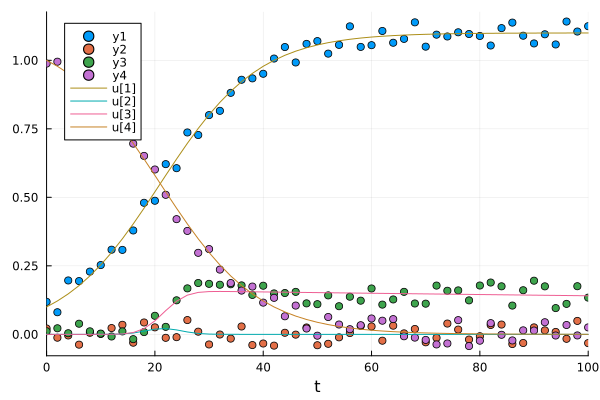

Experiment with feature as 0.8

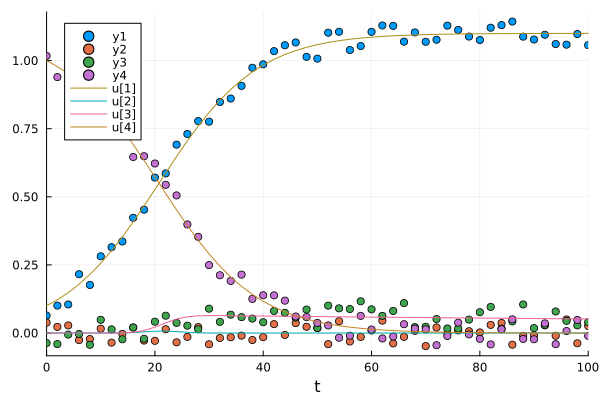

Experiment with feature as 0.9

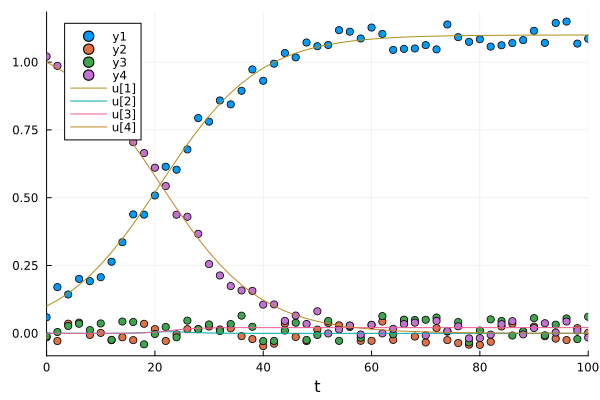

Experiment with feature as 1.0

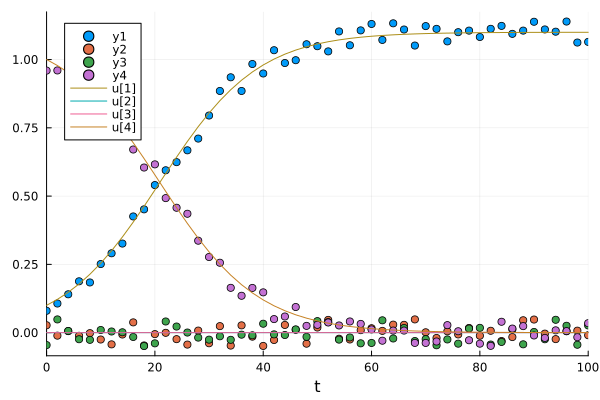

Experiment with feature as 1.1

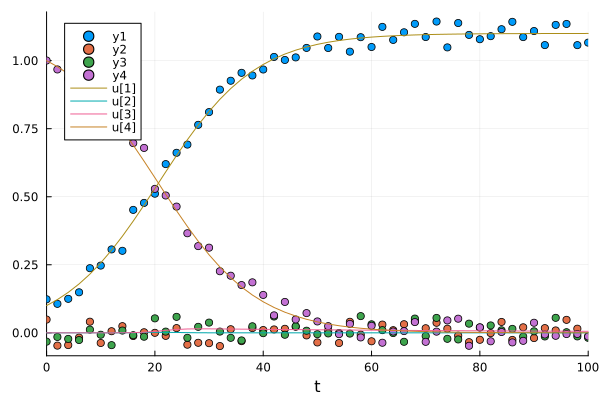

Experiment with feature as 1.2

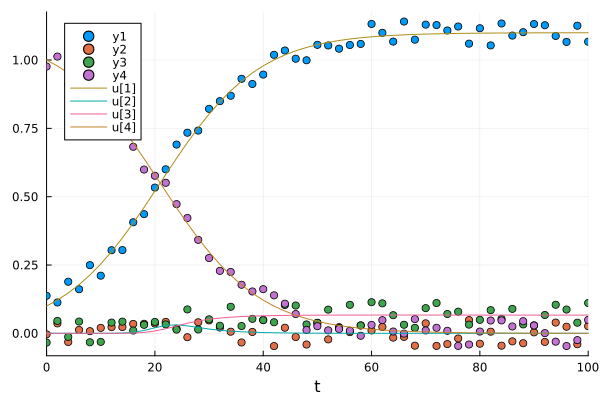

Experiment with feature as 1.3

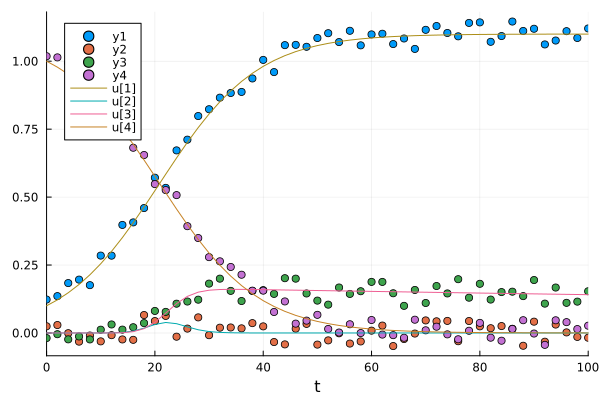

Experiment with feature as 1.4

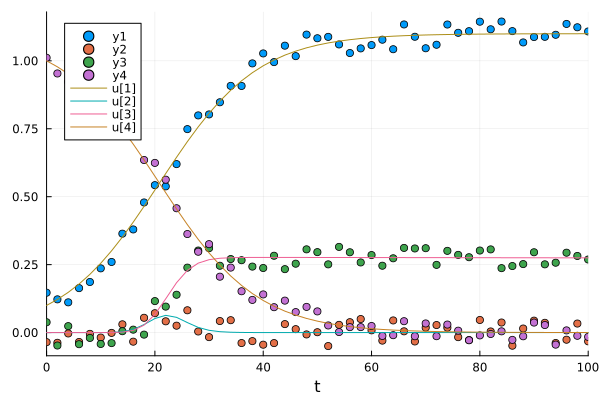

Experiment with feature as 1.5

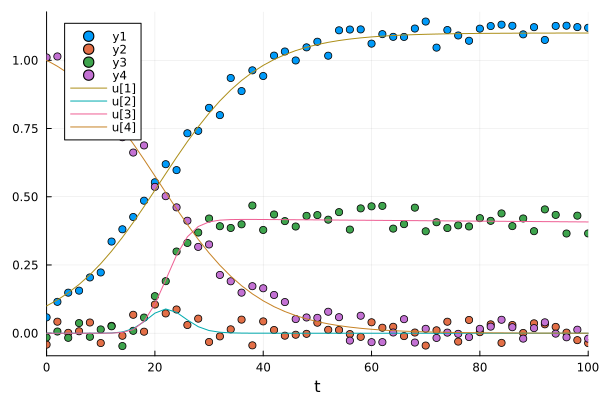

Experiment with feature as 1.6

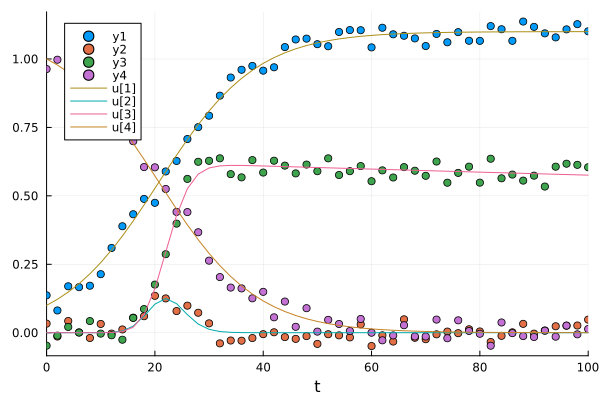

Experiment with feature as 1.7

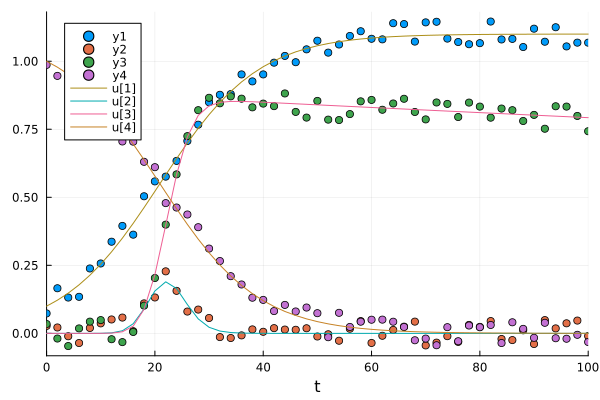

Experiment with feature as 1.8

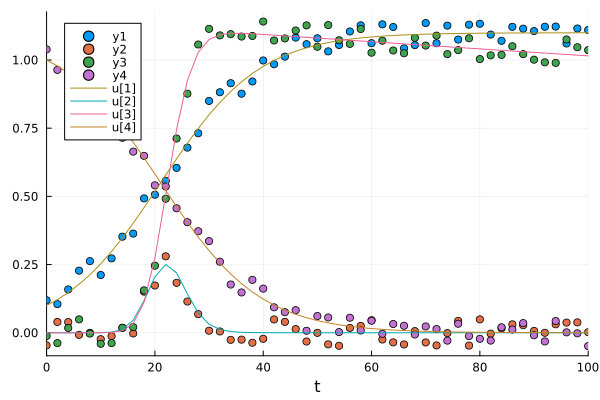

Experiment with feature as 1.9

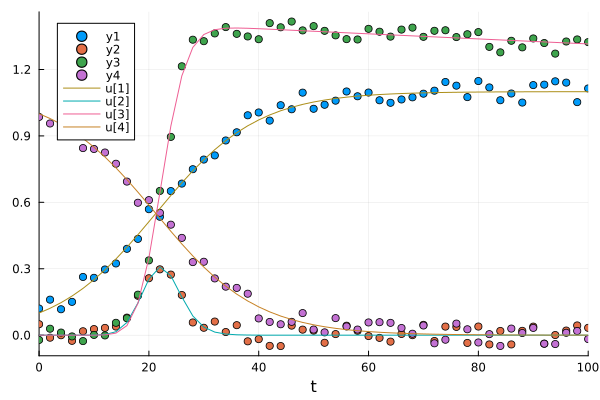

Experiment with feature as 2.0

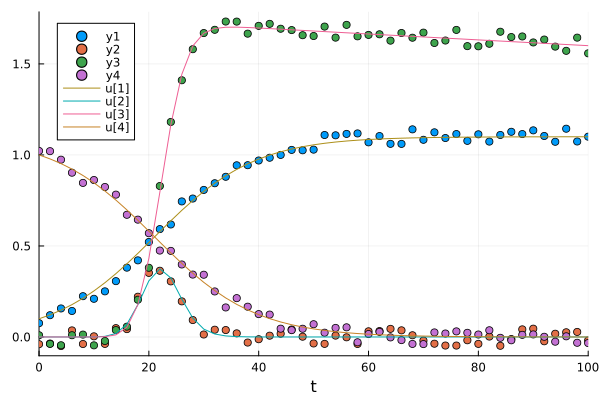

In [27]:
results_fit = Any
for f in feature_range
    plot(0, 0)

    # changing the parameters with unknown perturbation 
    param[4] = param0 * unknown_response(f)


    # Calling the simulation function
    Simulation =  ODEs_system_sim(
        model_1, #string of the model
        u0, # starting condition
        0.0, # start time of the sim
        100.0, # final time of the sim
        2.0, # delta t for poisson approx
        param; # parameters of the ODE model
    )
    
    # Plotting scatterplot of data without noise

    #adding uniform random noise
    sol_time = reduce(hcat, Simulation.t)
    sol_t = reduce(hcat,Simulation.u)
    noise_unifom = rand(Uniform(-0.05,0.05),size(sol_t)[2])
    sol_t_noise = [sol_t[i,:] .+ rand(Uniform(-0.05,0.05),size(sol_t)[2]) for i in 1:size(sol_t)[1]]
    sol_t_noise =permutedims(reduce(hcat,sol_t_noise))
    
    data = vcat(sol_time,sol_t_noise)
    # Plot data with noise
    scatter!(data[1,:],data[2,:])
    scatter!(data[1,:],data[3,:])
    scatter!(data[1,:],data[4,:])
    scatter!(data[1,:],data[5,:])

    

   fit = fit_ODEs_System(data,
                    string(f),
                    model_1, 
                    param_guess,
                    u0;
                    lb= lb1,
                   ub = ub1,
                  # set_of_equations_to_fit = [1,3,4]
    )

    display("text/html", "<h2>Experiment with feature as $f</h2>") 
    display(plot!(fit[3]))


    if f == feature_range[1]
        results_fit = fit[2]
    else
        results_fit = vcat(results_fit, reduce(hcat,fit[2][2,:]))
    end
end

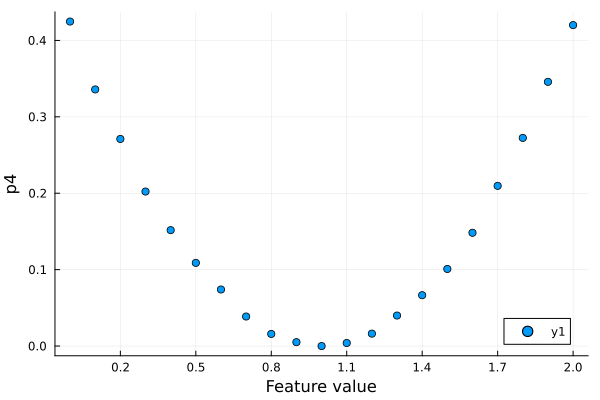

In [28]:
scatter(results_fit[2:end,1],results_fit[2:end,6],xlabel="Feature value", ylabel="p4",)

In [29]:
# setting option for symbolic regression
options = SymbolicRegression.Options(
    binary_operators=[+, /, *, -],
    unary_operators=[square],
    constraints=nothing,
    elementwise_loss=nothing,
    loss_function=nothing,
    tournament_selection_n=12,
    tournament_selection_p=0.86,
    topn=12,
    complexity_of_operators=nothing,
    complexity_of_constants=nothing,
    complexity_of_variables=nothing,
    parsimony=0.05,
    dimensional_constraint_penalty=nothing,
    alpha=0.100000,
    maxsize=10,
    maxdepth=nothing
)
# generating feature matrix
# the first column is the label as a string of the feature value we used for the fitting labeling

Options(binops=Function[+, /, *, -], unaops=Function[SymbolicRegression.CoreModule.OperatorsModule.square], bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=[-1], complexity_mapping=SymbolicRegression.CoreModule.OptionsStructModule.ComplexityMapping{Int64}(false, Int64[], Int64[], 1, 1), tournament_selection_n=12, tournament_selection_p=0.86, tournament_selection_weights=[0.86, 0.12040000000000001, 0.016856000000000003, 0.0023598400000000006, 0.0003303776000000001, 4.625286400000002e-5, 6.475400960000003e-6, 9.065561344000006e-7, 1.2691785881600008e-7, 1.7768500234240014e-8, 2.4875900327936024e-9, 3.482626045911044e-10], parsimony=0.05, dimensional_constraint_penalty=nothing, alpha=0.1, maxsize=10, maxdepth=10, turbo=false, migration=true, hof_migration=true, should_simplify=true, should_optimize_constants=true, output_file=hall_of_fame_2025-03-24_151142.789.csv, populations=15, perturbation_factor=0.076, annealing=false, batching=false, batch_size=50, mutation

In [30]:
feature_matrix = [[string(f),f] for f in feature_range]
feature_matrix = permutedims(reduce(hcat,feature_matrix))
results_fit[:,2] =results_fit[:,1] 
results_fit = permutedims(results_fit)
gr_sy_reg = Kinbiont.downstream_symbolic_regression(results_fit, feature_matrix, 6; options=options)

┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                              ┫ 0/150 [00:00<00:00, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.899e-02  3.604e+01  y = 0.15485                                   ---------------------------------------------------------------------------------------------------
4.0%┣█▉                                            ┫ 6/150 [00:00<00:02, 83it/s]Expressions evaluated per second: [.....]. Head worker occupation: 2.3%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:       

(Node{Float64}[0.15484862187133147, (0.13087425979402248 / (x1 + 0.3210580500044094)), square((0.9997051407438233 - x1) * -0.6495851582747723), square(((0.9997051407438233 - x1) * -0.6495851582747723) - square(5.198740318415419e-7))], Any["Complexity" 1 … 6 9; "MSE" 0.018988902321786655 … 9.196962122676769e-6 9.196962122676744e-6; "Equation" "0.15484862187133147" … "square((0.9997051407438233 - x1) * -0.6495851582747723)" "square(((0.9997051407438233 - x1) * -0.6495851582747723) - square(5.198740318415419e-7))"], [0.15484862187133147 0.40763425739434056 0.42171207639581804 0.421712076396169; 0.15484862187133147 0.31082236711221156 0.34156439341827016 0.341564393418586; … ; 0.15484862187133147 0.05892428601483994 0.34201230207235367 0.3420123020720376; 0.15484862187133147 0.05638560388171845 0.42220975267813304 0.4222097526777819], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

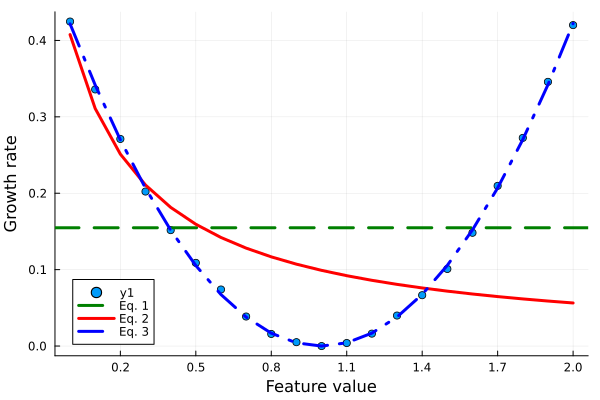

-10.0:0.1:10.0

In [32]:
scatter(results_fit[2,2:end],results_fit[6,2:end,],xlabel="Feature value", ylabel="Growth rate",)
hline!(unique(gr_sy_reg[3][:, 1]), label=["Eq. 1" nothing], line=(3, :green, :dash))
plot!(unique(results_fit[2,2:end]), unique(gr_sy_reg[3][:, 2]), label=["Eq. 2" nothing], line=(3, :red))
display(plot!(unique(results_fit[2,2:end]), unique(gr_sy_reg[3][:, 3]), label=["Eq. 3" nothing], line=(3, :blue, :dashdot)))
x = -10.0:0.1:10.0

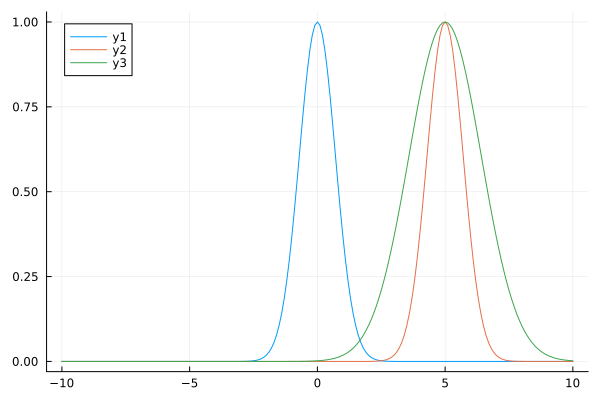

In [33]:
plot(x,exp.(.-x.^2))
plot!(x,exp.(.-(x .-5).^2))
plot!(x,exp.((.-(x .-5).^2)./4))